In [18]:
!pip install lime

#Imports

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)
from sklearn.inspection import PartialDependenceDisplay
from lightgbm import LGBMClassifier

In [20]:
X_train_final = pd.read_csv('/content/X_train_final.csv')
X_test_final = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [21]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## LightGBM Classifier Model

In [22]:
def clean_feature_names(df):
    df.columns = df.columns.str.replace(r"[\[\]\(\),<]", "_", regex=True)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)
    return df

X_train_final = clean_feature_names(X_train_final)
X_test_final = clean_feature_names(X_test_final)

[LightGBM] [Info] Number of positive: 2536, number of negative: 2176
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1131
[LightGBM] [Info] Number of data points in the train set: 4712, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.538200 -> initscore=0.153100
[LightGBM] [Info] Start training from score 0.153100

LightGBM Evaluation
Accuracy: 0.94
Precision: 0.94
Recall: 0.95
F1 Score: 0.94
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       544
           1       0.94      0.95      0.94       635

    accuracy                           0.94      1179
   macro avg       0.94      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



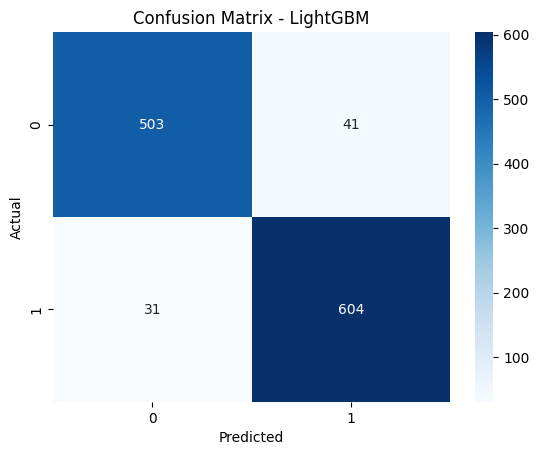

In [23]:
lgb_final = LGBMClassifier(random_state=42)
lgb_final.fit(X_train_final, y_train)
evaluate_model("LightGBM", lgb_final, X_test_final, y_test)

### SHAP for LightGBM


SHAP Summary for LightGBM


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


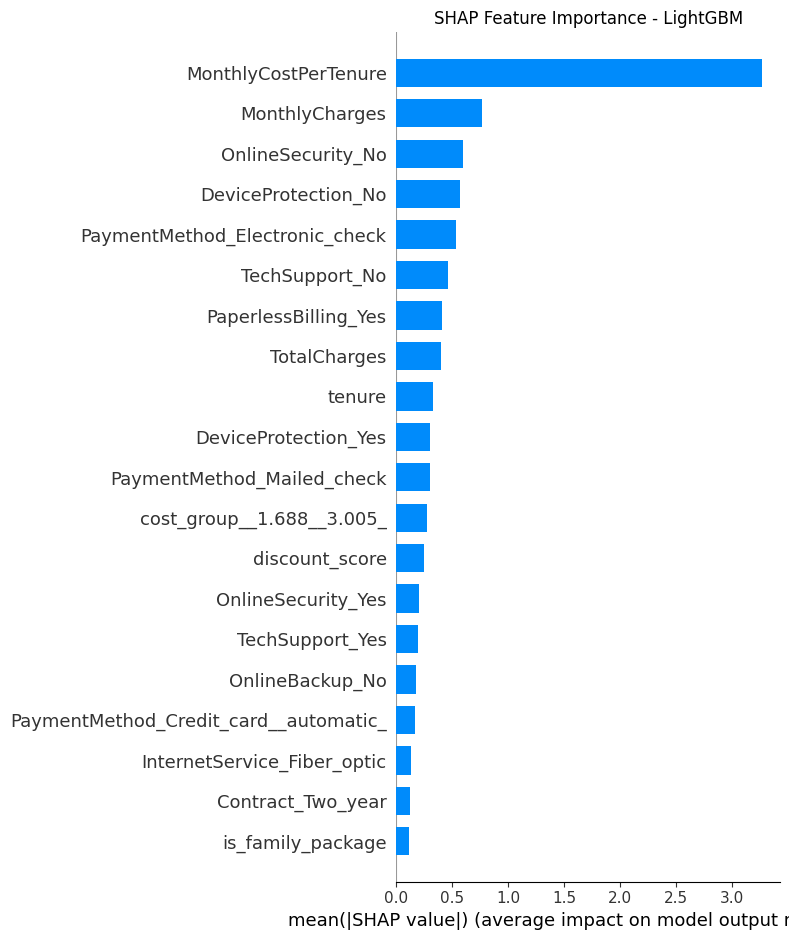

In [24]:
print("\nSHAP Summary for LightGBM")
explainer_lgb = shap.TreeExplainer(lgb_final)
shap_values_lgb = explainer_lgb.shap_values(X_test_final)
shap.summary_plot(shap_values_lgb, X_test_final, plot_type="bar", show=False)
plt.title("SHAP Feature Importance - LightGBM")
plt.tight_layout()
plt.show()

This SHAP summary plot shows the average feature impact on churn predictions:

* MonthlyCostPerTenure is by far the most important feature, suggesting customers who pay more relative to their tenure are much more likely to churn.

* MonthlyCharges, OnlineSecurity_No, and DeviceProtection_No also have significant contributions, indicating billing and lack of security services increase churn risk.

* Other features like contract type, support availability, and payment method have smaller but noticeable impacts.

The LightGBM model heavily relies on billing behavior and service availability to predict churn, with MonthlyCostPerTenure being the most influential driver.

### LIME for LightGBM

In [25]:
sample_instance = X_test_final.iloc[0]

explainer = LimeTabularExplainer(
    X_train_final.values,
    feature_names=X_train_final.columns.tolist(),
    class_names=['No Churn', 'Churn'],
    discretize_continuous=True
)

In [26]:
print("\nLIME Explanation for LightGBM")
exp = explainer.explain_instance(sample_instance.values, lgb_final.predict_proba)
exp.show_in_notebook()


LIME Explanation for LightGBM


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


This LIME explanation shows a local explanation for a single customer prediction:

* The model predicts a high probability of churn (84%).

* Key drivers toward churn include:

* High MonthlyCostPerTenure (contributes the most with +0.48),

* No Tech Support, Device Protection, or Online Security,

* Use of Electronic check as a payment method.

This customer pays a lot compared to how long they've been subscribed and lacks protection/support services, all of which increase churn risk. LIME confirms the global SHAP insights at an individual level.









### PDP for LightGBM

In [28]:
selected_feature = 'MonthlyCostPerTenure'
feature_index = X_train_final.columns.tolist().index(selected_feature)


PDP - LightGBM


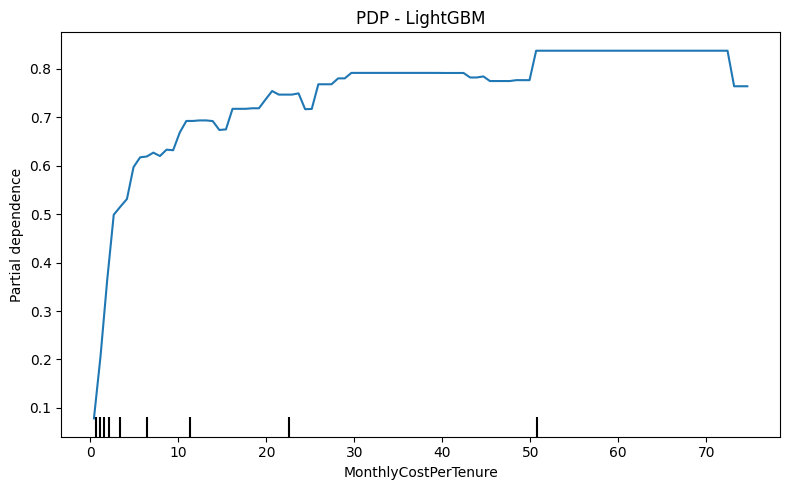

In [29]:
print("\nPDP - LightGBM")
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(lgb_final, X_test_final, [feature_index], ax=ax)
ax.set_title("PDP - LightGBM")
plt.tight_layout()
plt.show()

This PDP shows the relationship between MonthlyCostPerTenure and churn probability:

* Positive Correlation: As MonthlyCostPerTenure increases, the partial dependence (the predicted churn risk) rises rapidly.

* Plateau Behavior: Around a cost per tenure of ~30, the curve flattens, suggesting that beyond this point, increasing cost has little additional effect on churn risk.

Customers who are paying more relative to their tenure are significantly more likely to churn. This supports the idea that high early costs may cause dissatisfaction and early exits.

### ICE for LightGBM

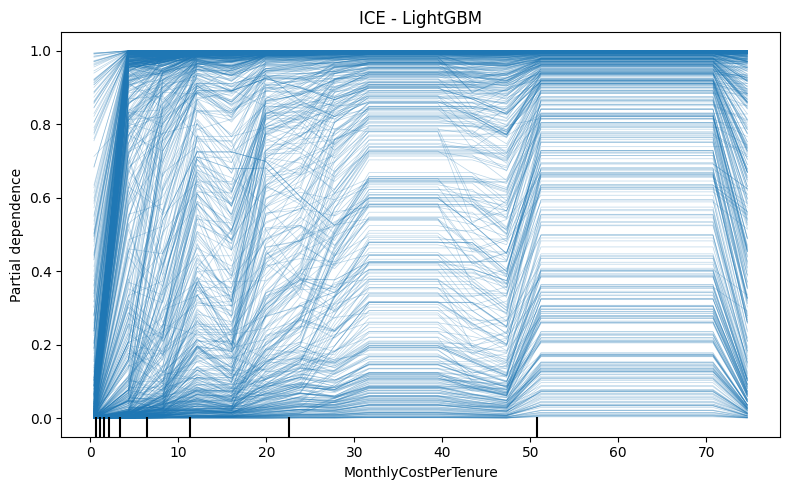

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
PartialDependenceDisplay.from_estimator(lgb_final, X_test_final, [feature_index], kind='individual', grid_resolution=20, ax=ax)
ax.set_title("ICE - LightGBM")
plt.tight_layout()
plt.show()

This ICE plot illustrates how the MonthlyCostPerTenure feature affects predicted churn probability at the individual level:

* Sharp early increase: For most instances, churn probability jumps sharply when cost per tenure is low—showing sensitivity to this feature early on.

* Horizontal lines: After a certain threshold (~30–50), most lines flatten, indicating saturation—higher cost per tenure no longer increases predicted churn significantly.

* Individual variation: The spread of lines at lower values shows that different customers respond differently, confirming model nonlinearity and heterogeneity in churn behavior.

High early costs are critical churn triggers, while later increases have diminishing effects.